# Create Connection

For each notebook, we always start with creation of a *SapioUser* object.

The *SapioUser* object describes the connection endpoint, and the api user authentication information.

# Dedicated Hosting
## Standard API Users
A dedicated, standard api-user object will require the following fields to be filled, at minimum:


*   url: The URL to the webservice.war tomcat deployment in the embedded tomcat of Sapio platform.
*   guid: The guid of the Sapio app you are connecting. There can be more than one app running on each Sapio BLS (DataMgmtServer). This will provide disambiguity to your credentials. You can find this information in Sapio Informatics Portal.
*   username: The username of the api user.
*   password: The password of the api user.

Sapio platform allows you to use the same API credential to connect concurrently, each concurrent connection will consume one concurrent connection seat.


To find the account/portal information, navigate to sapio portal and check the relevant app. In this example, my app guid is "3c232543-f407-4828-aae5-b33d4cd31fa7"

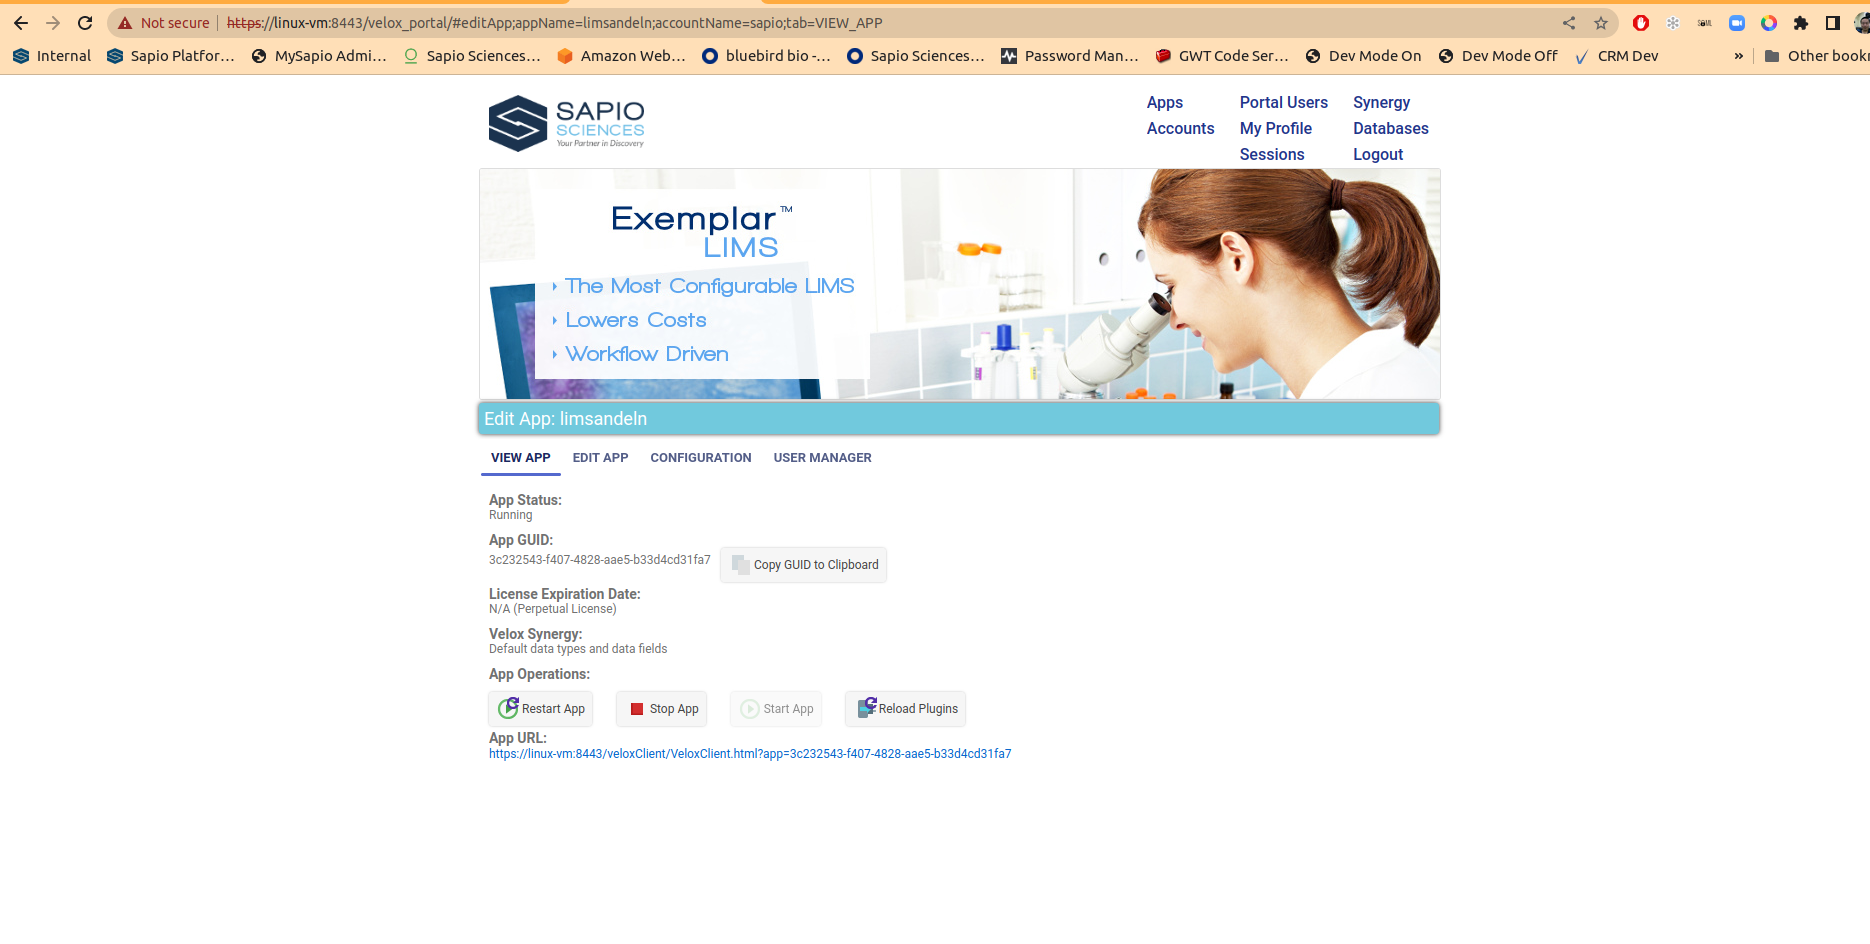

## Webservice API Users
These users are created in Configuration Manager => WebService API Key.

**The previous key is deleted and becomes invalid each time you re-generate. You will not be able to view this key after you finish generation, but you can reset-and-invalidate anytime.**

API users created this way will require the following attributes in SapioUser object:



*   url: The URL to the webservice.war tomcat deployment in the embedded tomcat of Sapio platform.
*   guid: The guid of the Sapio app you are connecting. There can be more than one app running on each Sapio BLS (DataMgmtServer). This will provide disambiguity to your credentials. You can find this information in Sapio Informatics Portal.
*   api_token: The key written to you when you click "*Request New Web Service API Key*" button.

# SaaS Customers
For SapioUser objects connecting to SaaS infrastructure (Bronze/Silver/Gold hosting solutions), the following parameters should be filled for SapioUser object:


*   url: The URL of your Sapio app website, followed by 'webservice/api'. For example: https://customer_name.exemplareln.dev/webservice/api or https://customer_name.exemplareln.com/webservice/api
*   api_token: The key written to you when you click "*Request New Web Service API Key*" button.
*   Leave the "guid" as "None". You do not need to fill this if you have a SaaS URL like so. Sapio will automatically map your URL to guid. 

**This may not work if you are using Sapio Platnium SaaS hosting with old SAML/SSO configs, or older hosting AMI. Refer to Dedicated Hosting SapioUser settings instead.**


In [ ]:
from sapiopylib.rest.User import SapioUser
from sapiopylib.rest.DataRecordManagerService import DataRecord
from sapiopylib.rest.DataRecordManagerService import DataRecordPojoPageCriteria
from sapiopylib.rest.DataMgmtService import DataMgmtServer
from sapiopylib.rest.DataRecordManagerService import DataRecordPojoHierarchyPageCriteria

user = SapioUser(url="https://linux-vm:8443/webservice/api",
                 guid="3c232543-f407-4828-aae5-b33d4cd31fa7", account_name="sapio",
                 username="pyRestTest", password="Password1!", verify_ssl_cert=False)
dataRecordManager = DataMgmtServer.get_data_record_manager(user)

We just created a new connection! In this case, we are not using api-token but rather we are specifying the guid, username, password instead.

These commands do not produce any results yet.

Now let's try to query for record ID = 1

We set Verify SSL to false because it's a SELF SIGNED CERT. In production, you want to keep this flag to true, and have real SSL certificate for Sapio Platform.

# Query Data Records

In [ ]:
result = dataRecordManager.query_data_records_by_id("Directory", [1])
if len(result.result_list) > 0:
    result_list: list = result.result_list
    element: DataRecord = result_list[0]
    print(element.get_record_id())
    print(element.get_fields())

1
{'CreatedBy': 'exemplar', 'DataRecordName': 'Root Directory', 'RelatedRecord3': None, 'RelatedRecord111': None, 'RelatedRecord110': None, 'VeloxLastModifiedDate': 1665609874605, 'VeloxLastModifiedBy': 'yqiao', 'DateCreated': 1659019678095, 'RecordId': 1, 'DirectoryName': 'Root Directory'}


/home/yqiao/anaconda3/envs/RDKit/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'linux-vm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In example above, we query a directory whose record ID is 1 (which by the way is the root directory. We print the record ID and the fields of the record.
Alternatively, you can direct print a DataRecordPojo object or a page's result directly. It will show the data record name of these data records.


In [ ]:
result = dataRecordManager.query_data_records("Sample", "SampleId", ["000007"])
print(result)

000007 export_COVID19 samples 23_04_20_ST3_COVID19_ICU_003_A...


/home/yqiao/anaconda3/envs/RDKit/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'linux-vm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Paging is available. In the next example we are going to get samples, 10 samples per page for 3 pages.

In [ ]:
next_page = DataRecordPojoPageCriteria(page_size=10)
for i in range(3):
    result = dataRecordManager.query_all_records_of_type("Sample", next_page)
    next_page = result.next_page_criteria
    print("Page " + str(i + 1) + ": " + str(result))
    if not result.is_next_page_available:
        break

/home/yqiao/anaconda3/envs/RDKit/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'linux-vm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/yqiao/anaconda3/envs/RDKit/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'linux-vm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/yqiao/anaconda3/envs/RDKit/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'linux-vm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Page 1: 000004, 000005, 000006, 000007 export_COVID19 samples 23_04_20_ST3_COVID19_ICU_003_A..., PyWebDemo-13, PyWebDemo-14, PyWebDemo-15, PyWebDemo-16, PyWebDemo-19, PyWebDemo-20[More Pages...]
Page 2: PyWebDemo-23, PyWebDemo-24, 000008, 000009, 000010, 000011, 000012, PyWebDemo-27, PyWebDemo-28, PyWebDemo-29[More Pages...]
Page 3: PyWebDemo-30, PyWebDemo-31, PyWebDemo-32, PyWebDemo-33, PyWebDemo-34, PyWebDemo-35, PyWebDemo-36, PyWebDemo-37, PyWebDemo-38, PyWebDemo-39[More Pages...]


query_system_for_record returns either the DataRecordPojo when it finds a record, or a "None" object if it's not found.

In [ ]:
result = dataRecordManager.query_system_for_record('Directory', 1)
print(result)
result = dataRecordManager.query_system_for_record('Directory', 1000000)
print(result)

Root Directory
None


/home/yqiao/anaconda3/envs/RDKit/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'linux-vm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/yqiao/anaconda3/envs/RDKit/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'linux-vm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


You can get parents and children of the records.
The easiest form is to take a single record and get children of that.

In this example, we find one FCS file and try to get its parent sample.

In [ ]:
fcs_result = dataRecordManager.query_all_records_of_type("FCSFile", DataRecordPojoPageCriteria(page_size=1))
if len(fcs_result.result_list) > 0:
    fcs_record = fcs_result.result_list[0]
    parents = dataRecordManager.get_parents(fcs_record.get_record_id(), "FCSFile", "Sample")
    if len(parents.result_list) > 0:
        parent_sample = parents.result_list[0]
        print(parent_sample)

000004


/home/yqiao/anaconda3/envs/RDKit/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'linux-vm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/yqiao/anaconda3/envs/RDKit/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'linux-vm'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In a slightly more complex case, we will be using a batch call to retrieve parents of multiple FCS children at once.

It is often much faster to use batch call than calling records in a loop. This will reduce the HTTP and remote overhead.

The result object is slightly different. To demonstrate paging in this situation, we will try to have a page of 10 on parents, for first five pages of parents for first 100 FCS records.
Note: Since each FCS record has a parent, this will not complete the entire query. The remaining pages will simply never be computed nor returned here.

In [ ]:
fcs_result = dataRecordManager.query_all_records_of_type("FCSFile", DataRecordPojoPageCriteria(page_size=100))
samples = list()
if len(fcs_result.result_list) > 0:
    fcs_record_id_list = [x.get_record_id() for x in fcs_result.result_list]
    fcs_record_by_record_id = dict((x.get_record_id(), x) for x in fcs_result.result_list)
    next_parent_page_criteria = DataRecordPojoHierarchyPageCriteria(page_size=10)
    for i in range(5):
        print("Page " + str(i + 1))
        parents = dataRecordManager.get_parents_list(fcs_record_id_list, "FCSFile", "Sample", next_parent_page_criteria)
        next_parent_page_criteria = parents.next_page_criteria
        for source_record_id, result_records in parents.result_map.items():
            if result_records is None or len(result_records) == 0:
                continue
            fcs_record = fcs_record_by_record_id.get(source_record_id)
            samples.extend(result_records)
            if fcs_record is not None:
                print(str(fcs_record) + " -> [" + ', '.join([str(x) for x in result_records]) + "]")
        if not parents.is_next_page_available:
            break

You can translate data in a list of data records into a pandas data frame, which can be used by external tools!

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', 100)
samples_data_frame = dataRecordManager.get_data_frame(samples)
display(samples_data_frame)

,ObservedCondition,MultiParentLink234,OtherSampleId,ActiveWorkflowId,SacrificedDate,RelatedNotebookExperiment,RelatedRecord170,SampleId,StorageLocationBarcode,Organism,CreatedBy,RelatedRecord146,CollectionDateTime,ElnbNumber,IsControl,PercentRecoveries,DataRecordName,Volume,ExemplarSampleType,RelatedChild123,ControlType,RelatedRecord181,TotalMass,ConcentrationUnits,RelatedRecord180,CollectionDate,RelatedRecord112,RelatedRecord111,RelatedRecord199,RelatedRecord110,TubeBarcode,DateCreated,MultiParentLink176,RelatedRecord119,IsPooled,RowPosition,ColPosition,VeloxLastModifiedBy,RecordId,ExemplarSampleStatus,MultiParentLink247,VolumeUnits,RelatedRecord168,RelatedRecord200,Comments,ContainerType,PreviousExemplarStatus,TimePoint,Concentration,Flags,RelatedPlate,MultiParentLink243,RelatedRecord208,StorageUnitPath,SapioSingleTemplateProcess,LastEditedBy,AssayType,VeloxLastModifiedDate,PlateId,RelatedChild149,TatProgressStatus,IsInvalid
0,,None,,None,None,None,None,000004,,,sdmsapi,None,None,,False,None,000004,None,,None,,None,None,ng/uL,None,None,None,None,None,None,,1663688244010,None,None,False,,,sdmsapi,130,,None,,None,None,,,,None,None,,,None,None,,,,,1663688244522,,None,,False
1,,None,,None,None,None,None,000005,,,sdmsapi,None,None,,False,None,000005,None,,None,,None,None,ng/uL,None,None,None,None,None,None,,1663688248670,None,None,False,,,sdmsapi,132,,None,,None,None,,,,None,None,,,None,None,,,,,1663688248737,,None,,False
2,,None,,None,None,None,None,000006,,,sdmsapi,None,None,,False,None,000006,None,Flow Cytometry,None,,None,None,ng/uL,None,None,None,None,None,None,,1663688707312,None,None,False,,,sdmsapi,169,,None,,None,None,,,,None,None,,,None,None,,,,,1663688707708,,None,,False
3,,None,export_COVID19 samples 23_04_20_ST3_COVID19_IC...,None,None,None,None,000007,,,sdmsapi,None,None,,False,None,000007 export_COVID19 samples 23_04_20_ST3_COV...,None,Flow Cytometry,None,,None,None,ng/uL,None,None,None,None,None,None,,1663693730249,None,None,False,,,sdmsapi,171,,None,,None,None,,,,None,None,,,None,None,,,,,1663693730582,,None,,False
